## Introduction to Interpreted GenJAX

This notebook is an early experiment with porting the content of the sibling [intro_to_genjax](intro_to_genjax.ipynb) notebook using only the features of the Interpreted language (i.e., we don't use JAX vmap or JIT compilation). The goal at present is just to examine what such a thing would look like and so I have not copied over the exposition in that notebook. The commentary highlights the differences observed.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np

import genjax
import matplotlib.pyplot as plt
from genjax import lang, Interpreted
key = jax.random.PRNGKey(314159) 
console = genjax.console(enforce_checkify=True, width=60)

In [2]:
@lang(Interpreted)
def g(x):
    m0 = genjax.bernoulli(x) @ "m0"
    return m0
    
@lang(Interpreted)
def h(x):
    m0 = g(x) @ "sub"
    return m0

In [3]:
key, sub_key = jax.random.split(key)
tr = h.simulate(sub_key, (0.3,))
console.print(tr)

InterpretedTrace
├── gen_fn
│   └── InterpretedGenerativeFunction
│       └── source
│           └── <function h>
├── args
│   └── tuple
│       └── (const) 0.3
├── retval
│   └──  i32[]
├── choices
│   └── Trie
│       └── :sub
│           └── InterpretedTrace
│               ├── gen_fn
│               │   └── InterpretedGenerativeFunction
│               │       └── source
│               │           └── <function g>
│               ├── args
│               │   └── tuple
│               │       └── (const) 0.3
│               ├── retval
│               │   └──  i32[]
│               ├── choices
│               │   └── Trie
│               │       └── :m0
│               │           └── DistributionTrace
│               │               ├── gen_fn
│               │               │   └── TFPDistribution
│               │               │       └── make_distribution
│               │               │           └── <function <lambda>>
│               │               ├── args
│               │               │   └── tuple
│               │               │       └── (const) 0.3
│               │               ├── value
│               │               │   └──  i32[]
│               │               └── score
│               │                   └──  f32[]
│               └── score
│                   └──  f32[]
└── score
    └──  f32[]

In [4]:
key, sub_key = jax.random.split(key)
tr = genjax.normal.simulate(sub_key, (0.0, 1.0))
tr

DistributionTrace(gen_fn=TFPDistribution(make_distribution=<class 'tensorflow_probability.substrates.jax.distributions.normal.Normal'>), args=(0.0, 1.0), value=Array(0.27442896, dtype=float32), score=Array(-0.95659417, dtype=float32))

In [5]:
@lang(Interpreted)
def h(x):
    m1 = genjax.bernoulli(x) @ "m0"
    m2 = genjax.bernoulli(x) @ "m1"
    return m1 + m2

key, sub_key = jax.random.split(key)
tr = h.simulate(sub_key, (0.3,))
console.print(tr)   

InterpretedTrace
├── gen_fn
│   └── InterpretedGenerativeFunction
│       └── source
│           └── <function h>
├── args
│   └── tuple
│       └── (const) 0.3
├── retval
│   └──  i32[]
├── choices
│   └── Trie
│       ├── :m0
│       │   └── DistributionTrace
│       │       ├── gen_fn
│       │       │   └── TFPDistribution
│       │       │       └── make_distribution
│       │       │           └── <function <lambda>>
│       │       ├── args
│       │       │   └── tuple
│       │       │       └── (const) 0.3
│       │       ├── value
│       │       │   └──  i32[]
│       │       └── score
│       │           └──  f32[]
│       └── :m1
│           └── DistributionTrace
│               ├── gen_fn
│               │   └── TFPDistribution
│               │       └── make_distribution
│               │           └── <function <lambda>>
│               ├── args
│               │   └── tuple
│               │       └── (const) 0.3
│               ├── value
│               │   └──  i32[]
│               └── score
│                   └──  f32[]
└── score
    └──  f32[]

In [6]:
selection = genjax.select("m1")
selected = tr.get_choices().filter(selection)
selected

HierarchicalChoiceMap(trie=Trie(inner={'m1': ChoiceValue(value=Array(1, dtype=int32))}))

In [7]:
@lang(Interpreted)
def model_y(x, coefficients):
    basis_value = jnp.array([1.0, x, x**2])
    polynomial_value = jnp.sum(basis_value * coefficients)
    y = genjax.normal(polynomial_value, 0.3) @ "value" 
    return y 

@lang(Interpreted)
def outlier_model(x, coefficients):
    basis_value = jnp.array([1.0, x, x**2])
    polynomial_value = jnp.sum(basis_value * coefficients)
    y = genjax.normal(polynomial_value, 30.0) @ "value"
    return y

The first big difference is below. In Static, we use the `@lang(Map)` decoration to use the map combinator on the kernel function. In this replacement, we handle the vectorization manually, using a composite index. Question: is there a syntax which would allow the creation of a vector choice map here?

We also do not have the `Switch` combinator available, so we handle the switch with an expression. Taking a second look at the assembly of the `y` array, it might have been written more clearly as a for loop. To that end I wrote `kernel2`, a less dense way of doing it. 

In [8]:

@lang(Interpreted)
def kernel(xs, coefficients):
    is_outlier = jnp.array([genjax.flip(0.1) @ ("outlier", i) for i in range(len(xs))]) 
    y = jnp.array([
        (outlier_model if is_outlier[i] else model_y)(xs[i], coefficients) @ ("y", i)
        for i in range(len(xs))
    ])
    return y

@lang(Interpreted)
def kernel2(xs, coefficients):
    y = []
    for i, x in enumerate(xs):
        is_outlier = genjax.flip(0.1) @ ("outlier", i)
        
        if is_outlier:
            model = outlier_model
        else:
            model = model_y
            
        y.append(model(x, coefficients) @ ("y", i))
        
    return jnp.array(y)

@lang(Interpreted)
def model(xs):
    coefficients = genjax.mv_normal(jnp.zeros(3), 2.0 * jnp.identity(3)) @ "alpha"
    ys = kernel2(xs, coefficients) @ "ys"
    return ys

In [9]:
data = jnp.arange(0, 10, 0.5)
key, sub_key = jax.random.split(key)
tr = model.simulate(sub_key, (data,))
tr.strip()

HierarchicalChoiceMap(trie=Trie(inner={'ys': HierarchicalChoiceMap(trie=Trie(inner={'y': Trie(inner={0: HierarchicalChoiceMap(trie=Trie(inner={'value': ChoiceValue(value=Array(0.2172786, dtype=float32))})), 1: HierarchicalChoiceMap(trie=Trie(inner={'value': ChoiceValue(value=Array(2.1709547, dtype=float32))})), 2: HierarchicalChoiceMap(trie=Trie(inner={'value': ChoiceValue(value=Array(3.9315705, dtype=float32))})), 3: HierarchicalChoiceMap(trie=Trie(inner={'value': ChoiceValue(value=Array(8.067581, dtype=float32))})), 4: HierarchicalChoiceMap(trie=Trie(inner={'value': ChoiceValue(value=Array(12.636509, dtype=float32))})), 5: HierarchicalChoiceMap(trie=Trie(inner={'value': ChoiceValue(value=Array(17.12947, dtype=float32))})), 6: HierarchicalChoiceMap(trie=Trie(inner={'value': ChoiceValue(value=Array(24.022703, dtype=float32))})), 7: HierarchicalChoiceMap(trie=Trie(inner={'value': ChoiceValue(value=Array(31.769226, dtype=float32))})), 8: HierarchicalChoiceMap(trie=Trie(inner={'value': Ch

In [10]:
tr.get_retval()

Array([  0.2172786,   2.1709547,   3.9315705,   8.067581 ,  12.636509 ,
        17.12947  ,  24.022703 ,  31.769226 ,  39.97427  ,  67.01651  ,
        59.81299  ,  70.8174   ,  82.77178  ,  96.045135 , 110.35339  ,
       112.32442  , 141.16861  , 157.76257  , 175.96541  , 195.11928  ],      dtype=float32)

In [12]:
chm = tr.get_choices()
values = [chm["ys", "y", i, "value"] for i in range(len(data))]
values

[Array(0.2172786, dtype=float32),
 Array(2.1709547, dtype=float32),
 Array(3.9315705, dtype=float32),
 Array(8.067581, dtype=float32),
 Array(12.636509, dtype=float32),
 Array(17.12947, dtype=float32),
 Array(24.022703, dtype=float32),
 Array(31.769226, dtype=float32),
 Array(39.97427, dtype=float32),
 Array(67.01651, dtype=float32),
 Array(59.81299, dtype=float32),
 Array(70.8174, dtype=float32),
 Array(82.77178, dtype=float32),
 Array(96.045135, dtype=float32),
 Array(110.35339, dtype=float32),
 Array(112.32442, dtype=float32),
 Array(141.16861, dtype=float32),
 Array(157.76257, dtype=float32),
 Array(175.96541, dtype=float32),
 Array(195.11928, dtype=float32)]

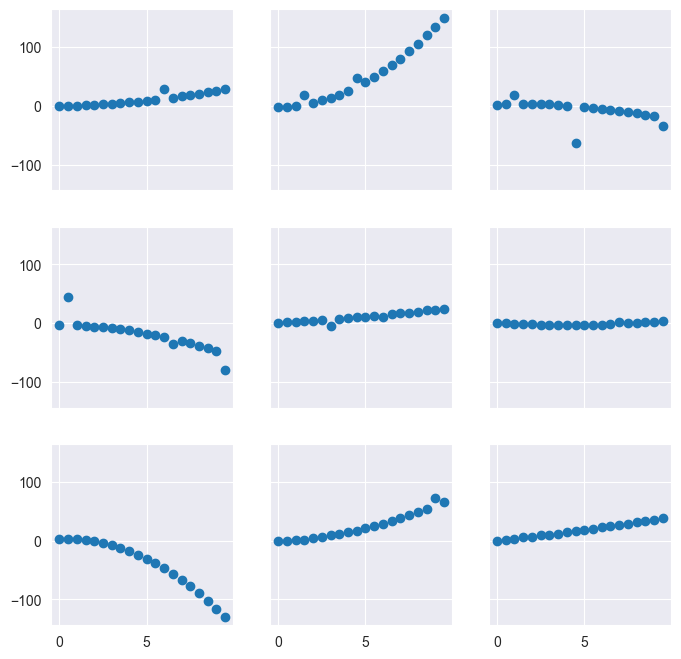

In [13]:
def get_ys(chm):
    return [chm["ys", "y", i, "value"] for i in range(len(data))]

f, axes = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)
for ax in axes.flatten():
    key, subkey = jax.random.split(key)
    tr = model.simulate(key, (data,))
    ax.scatter(data, tr.get_retval())


In [14]:
x = np.array([0.3, 0.7, 1.1, 1.4, 2.3, 2.5, 3.0, 4.0, 5.0])
y = 2.0 * x + 1.5 + x ** 2
y[2] = 50.0

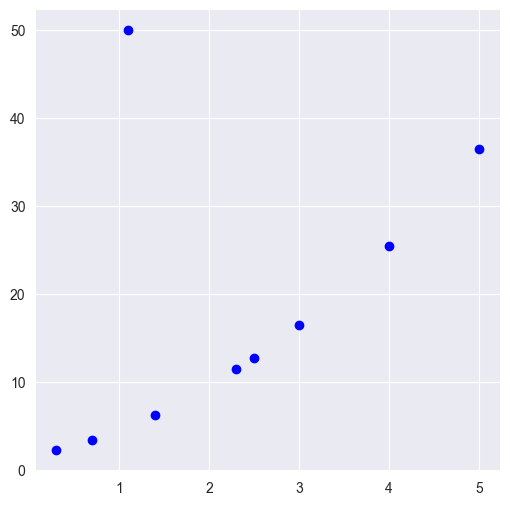

In [15]:
fig_data, ax_data = plt.subplots(figsize=(6, 6))
ax_data.scatter(x, y, color="blue")

There needs to be a better way to build this map. `genjax.choice_map` only works one layer deep, so you have to keep repeating it. 

In [16]:
observations = genjax.choice_map(
    {"ys": genjax.choice_map(
        {"y": genjax.choice_map(
            {i: genjax.choice_map({"value": y}) for i, y in enumerate(y)}
        )}
    )}
)

In [16]:
key, sub_key = jax.random.split(key)
(tr, w) = model.importance(sub_key, observations, (x,))

In [17]:
w, tr.get_score()

(Array(-35950.492, dtype=float32), Array(-35955.53, dtype=float32))

In [18]:
def sampling_importance_resampling(model, n_samples):
    def _inner(key, observations, model_args):
        resample_key, sub_key = jax.random.split(key)
        sub_keys = jax.random.split(sub_key, n_samples)
        tr_lw_pairs = [model.importance(sub_key, observations, model_args) for sub_key in sub_keys]
        trs = [tr_lw[0] for tr_lw in tr_lw_pairs]
        lws = [tr_lw[1] for tr_lw in tr_lw_pairs]
        index = genjax.categorical.sample(resample_key, lws)
        # I'm not certain this is what was intended
        return tr_lw_pairs[index][0]
        
    return _inner      

Here's another difference: we can't afford to do 100x100 runs of this; even at N=20, 40 it takes too long. I found that increasing the n_samples argument to `sampling_importance_sampling` improves the outlier detection.

In [19]:
N = 20
model_args = (x,)
key, *sub_keys = jax.random.split(key, N+1)
samples = [sampling_importance_resampling(model, 2*N)(sub_key, observations, model_args) for sub_key in sub_keys]
coefficients = [s["alpha"] for s in samples]
coefficients

[Array([ 0.89368355, -0.77476174,  1.7047914 ], dtype=float32),
 Array([1.3165519, 0.3804909, 0.5967533], dtype=float32),
 Array([ 0.25719795, -0.76179147,  0.8454422 ], dtype=float32),
 Array([ 1.7223147, -1.0900421,  1.661867 ], dtype=float32),
 Array([0.6506175, 1.2879071, 1.1480987], dtype=float32),
 Array([1.3526324 , 0.02778184, 1.3484421 ], dtype=float32),
 Array([0.6539184, 1.9262357, 0.9660401], dtype=float32),
 Array([0.75020975, 0.7904193 , 1.1328939 ], dtype=float32),
 Array([0.93024313, 1.5645299 , 0.84403735], dtype=float32),
 Array([ 2.1031833 , -0.18017174,  1.662884  ], dtype=float32),
 Array([ 1.1669074,  1.7291132, -0.7634985], dtype=float32),
 Array([ 2.0054667 , -0.14980228,  0.9579936 ], dtype=float32),
 Array([ 1.4715773, -2.2106583,  1.4579651], dtype=float32),
 Array([ 2.7558699 , -0.01429411,  1.3474296 ], dtype=float32),
 Array([ 1.9532672 , -0.58997726,  1.292121  ], dtype=float32),
 Array([0.7461676, 0.4737683, 1.2697573], dtype=float32),
 Array([-1.5494082

In [20]:
def polynomial_at_x(x, coefficients):
    basis_values = jnp.array([1.0, x, x**2])
    polynomial_value = jnp.sum(coefficients * basis_values)
    return polynomial_value

def plot_polynomial_values(ax, x, coefficients, **kwargs):
    ax_inf.plot(x, [polynomial_at_x(x, coefficients) for x in x], alpha=0.2)
    

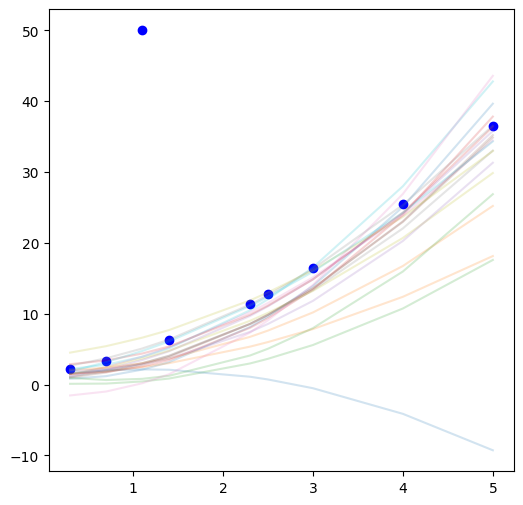

In [21]:
fig_inf, ax_inf = plt.subplots(figsize=(6, 6))
ax_inf.scatter(x, y, color="blue")
for cs in coefficients:
    plot_polynomial_values(ax_inf, x, cs)

In [31]:
outlier_at_2 = [s["ys", "outlier", 2] for s in samples]

In [32]:
np.sum(outlier_at_2) / len(outlier_at_2)

0.8